In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import h5py
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from GNN.utils.datautils import  get_data
from scipy.optimize import curve_fit
from sklearn.metrics import confusion_matrix
from GNN.utils.cm import plot_confusion_matrix
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.mock_observables import tpcf
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
import pandas as pd
import pickle
import seaborn as sns
sns.set_context('talk')

In [75]:
output_file = 'merged_dataframe.h5'
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'
 
train, test = get_data(data_path + output_file, arg_label = 'both')

In [76]:
train.head()

,ID_DMO,ID_HYDRO,M200_DMO,M200_HYDRO,M200c,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,...,x_offset,x_dmo,y_dmo,z_dmo,N_gals,M_stars,x_hydro,y_hydro,z_hydro,labels
131073,225031,240522,1.099000e+11,9.548000e+10,1.098593e+11,0.008820,77.896492,7.866057,6.573355e+06,1.127003,...,1936.219399,286.087812,284.226250,294.378750,0.0,3.390875e+08,286.094969,284.223031,294.375281,False
2,7238,5392,2.402000e+12,2.440000e+12,2.402108e+12,0.352976,217.811813,3.177258,7.646312e+05,0.458952,...,529.864573,151.945797,44.601000,157.183750,8.0,1.215231e+11,151.954688,44.607535,157.211750,True
131074,211548,240523,1.197000e+11,1.006000e+11,1.197391e+11,0.014888,80.161522,11.203557,1.596397e+07,0.814929,...,604.320757,294.960625,3.876552,279.140125,0.0,3.599013e+08,294.971500,3.869190,279.136781,False
4,5543,6160,6.915000e+12,5.426000e+12,6.914848e+12,0.085405,309.844360,8.628157,8.548512e+06,0.955517,...,515.772693,297.496688,164.154469,148.109125,3.0,1.768937e+11,297.516219,164.154078,148.116297,True
5,7681,6173,3.631000e+12,3.173000e+12,3.630934e+12,0.200317,249.969940,3.840995,1.224789e+06,0.390785,...,367.230657,33.252168,93.309883,121.395938,8.0,1.258065e+11,33.300016,93.468781,121.208062,True


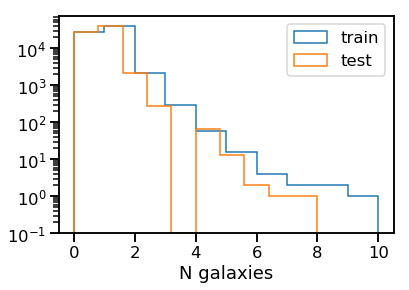

In [77]:
plt.hist(train.N_gals, log=True, histtype='step', label = 'train')
plt.hist(test.N_gals, log=True, histtype='step', label = 'test')
plt.xlabel('N galaxies')
plt.legend()

In [78]:
bins = np.logspace(np.log10(0.01), np.log10(800), 20)

Text(0.5,0,'$M_{200c}$')

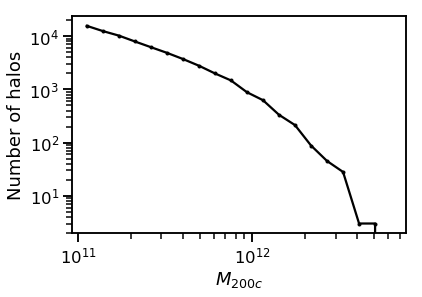

In [79]:
nbins= 20
bins = np.logspace(np.log10(np.min(train.M200c)),
                   np.log10(np.max(train.M200c)), nbins+1)

bin_centers = (bins[1:]+bins[:-1])/2.

mass_func, edges = np.histogram(train.M200c, bins=bins)
plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='black', marker='o',markersize=3)

plt.ylabel('Number of halos')
plt.xlabel(r'$M_{200c}$')

# Fit HOD parameters to training set

In [80]:
n_centrals = train.labels
n_satellites = train.N_gals - 1

In [81]:
n_centrals_binned, edges, _ = binned_statistic(train.M200c, n_centrals, statistic = 'mean',
                                     bins=bins)

n_centrals_error, edges, _ = binned_statistic(train.M200c, n_centrals, statistic = 'std',
                                     bins=bins)

In [82]:
n_satellites_binned, edges, _ = binned_statistic(train.M200c, n_satellites, statistic = 'mean',
                                     bins=bins)

n_satellites_error, edges, _ = binned_statistic(train.M200c, n_satellites, statistic = 'std',
                                     bins=bins)

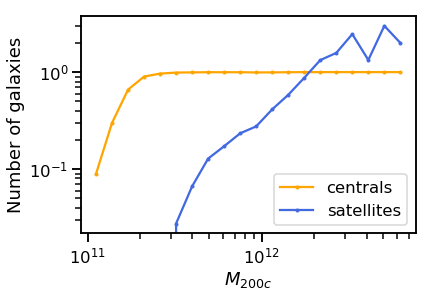

In [83]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

## Find HOD parameters

In [84]:
cen_model = Zheng07Cens()

def mean_centrals(mass, logMin, sigma_logM):

    cen_model.param_dict = {'logMmin': logMin,
                    'sigma_logM': sigma_logM}
    
    return cen_model.mean_occupation(prim_haloprop = mass)

sats_model = Zheng07Sats()

def mean_sats(mass, M0, M1, alpha):
    
    logM0 = np.log10(M0)

    logM1 = np.log10(M1)
    
    sats_model.param_dict = {'logM0': logM0, 
                'logM1': logM1, 'alpha': alpha}
    
    return sats_model.mean_occupation(prim_haloprop = mass)
    


In [85]:
popt_central, pcov_central = curve_fit(mean_centrals, bin_centers,
                      n_centrals_binned,
                    p0 = list(cen_model.param_dict.values()))

In [86]:
popt_sats, pcov_sats = curve_fit(mean_sats, bin_centers,
                      n_satellites_binned,
                    p0 =list(sats_model.param_dict.values()))

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [87]:
nbins= 30
masses = np.logspace(np.log10(np.min(train.M200c)),
                   np.log10(np.max(train.M200c)), nbins+1)

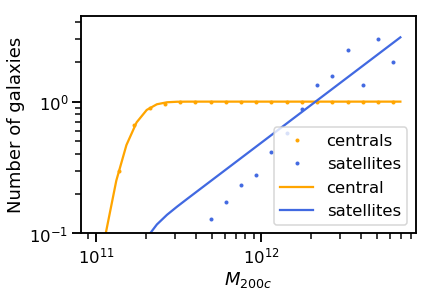

In [88]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals', linestyle='')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites', linestyle='')

cen_model.param_dict = {'logMmin':popt_central[0], 'sigma_logM': popt_central[1]}

sats_model.param_dict = {'logM0': np.log10(popt_sats[0]), 
                'logM1': np.log10(popt_sats[1]), 'alpha': popt_sats[2]}
ax.plot(masses,
           cen_model.mean_occupation(prim_haloprop = masses), #yerr = n_satellites_error, 
             color='orange',
        label = 'central')

ax.plot(masses,
          cen_model.mean_occupation(prim_haloprop = masses)*  sats_model.mean_occupation(prim_haloprop = masses) , #yerr = n_satellites_error, 
             color='royalblue',
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.ylim(1e-1)
plt.legend()

# Performance on test set

In [89]:
np.random.seed(22222)

Udf = np.random.uniform(0,1,len(test))

N_mean_cen = cen_model.mean_occupation(prim_haloprop = test.M200c)



In [90]:
Nc_test = (N_mean_cen > Udf).astype(int)

In [91]:
cm = confusion_matrix(test.labels, Nc_test)

Normalized confusion matrix


(array([[0.75550952, 0.24449048],
        [0.16702115, 0.83297885]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2b6465b9f390>)

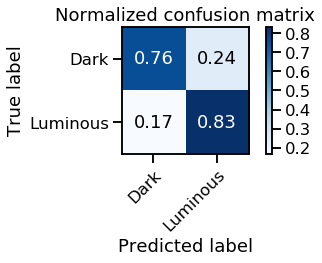

In [92]:
plot_confusion_matrix(test.labels,
    Nc_test, classes = ['Dark', 'Luminous'], 
    normalize = True)

## Two point correlation function for the test set central galaxies

In [93]:
pos_test = np.vstack((test.x_hydro, test.y_hydro, test.z_hydro)).T.clip(0.)
boxsize = np.max(pos_test)
pos_test_galaxies = pos_test[test.N_gals > 0]

r = np.geomspace(0.3, 30., 50)

test_tpcf = tpcf(pos_test_galaxies, rbins = r, period = boxsize, estimator =  'Landy-Szalay' )

In [94]:
pos_test.shape

(69842, 3)

In [95]:
pos_test_galaxies.shape

(41845, 3)

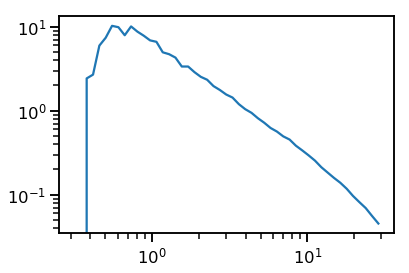

In [96]:
r_c = 0.5 * (r[1:] + r[:-1])
plt.loglog(r_c, test_tpcf)

## Populate halo catalog

In [103]:
test.ID_DMO.shape

(69842,)

In [104]:
test.x_dmo.shape

(69842,)

In [105]:
test.M200c.shape

(69842,)

In [109]:
test.R200c.values

array([294.48864746,  77.41929626, 271.26589966, ...,  89.47777557,
        78.51371002, 113.57344818])

In [100]:
velocities = np.random.random((len(test), 3))

In [118]:
halocat = UserSuppliedHaloCatalog( redshift = 0., Lbox = boxsize, 
        halo_x =test.x_dmo.values.clip(0), halo_y = test.y_dmo.values, halo_z = test.z_dmo.values,
        halo_vx = velocities[:,0], halo_vy = velocities[:,1], halo_vz = velocities[:,2],
        halo_mvir = test.M200c.values, halo_id = test.ID_DMO.values, halo_hostid = test.ID_DMO.values,
        particle_mass = 1e9, halo_upid = -1. * np.ones_like(test.ID_DMO),
        halo_rvir = test.R200c.values
        )

In [119]:
cens_prof_model = TrivialPhaseSpace()

In [120]:
#sats_prof_model = TrivialPhaseSpace()

In [121]:
model_instance = HodModelFactory(
    centrals_occupation = cen_model,
    centrals_profile = cens_prof_model)

In [122]:
model_instance.populate_mock(halocat)

In [123]:
type(model_instance.mock.galaxy_table)

astropy.table.table.Table

In [124]:
df_mock_test = pd.DataFrame(np.array(model_instance.mock.galaxy_table))

In [125]:
len(df_mock_test)

16029

In [126]:
pos_test_mock = np.vstack([df_mock_test['x'], 
                           df_mock_test['y'],
                           df_mock_test['z']]
                         ).T

In [127]:
pos_test_mock.shape

(16029, 3)

In [128]:
#r, clustering = model_instance.mock.compute_galaxy_clustering(gal_type = 'centrals') 

mock_tpcf = tpcf(pos_test_mock, rbins = r, period = boxsize, estimator =  'Landy-Szalay' )

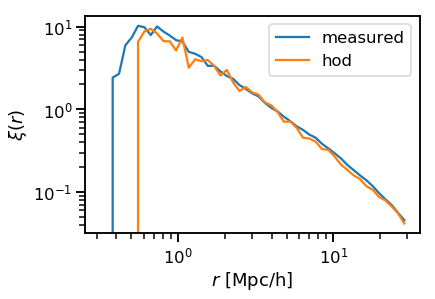

In [137]:
plt.loglog(r_c, test_tpcf, label = 'measured')
plt.loglog(r_c, mock_tpcf, label = 'hod')
plt.ylabel(r'$\xi (r)$')

plt.xlabel(r'$r \, \, \mathrm{[Mpc/h]}$')
plt.legend()

Text(0.5,0,'$r \\, \\, \\mathrm{[Mpc/h]}$')

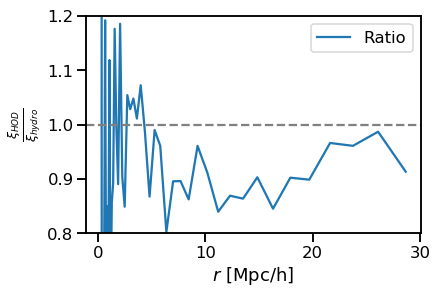

In [135]:
plt.plot(r_c, mock_tpcf/test_tpcf, label = 'Ratio')
plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)
plt.ylabel(r'$\frac{\xi_{HOD}}{\xi_{hydro}}$')

plt.xlabel(r'$r \, \, \mathrm{[Mpc/h]}$')

In [42]:
hod_tpcf_dict = {
        'r_c': r_c,
        'tpcf': mock_tpcf,
                }

In [43]:
with open('hod_tpcf.pkl', 'wb') as f:
    pickle.dump(hod_tpcf_dict, f)